In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from fastpm import core
import numpy
from fastpm.core import leapfrog

from pmesh.pm import ParticleMesh
from nbodykit.cosmology import Planck15
from kdcount import KDTree

In [12]:
from fastpm.glass import Solver

In [5]:
from nbodykit.cosmology.background import MatterDominated

In [29]:
pm = ParticleMesh(BoxSize=512., Nmesh=[32, 32, 32])

def test_solver(B=2, spread=3, N=3):
    solver= Solver(pm, B)
    Q = pm.generate_uniform_particle_grid()
    state = solver.run(3333, Q, spread=spread, N=N)
    
    return state


In [30]:
from nbodykit.lab import *

------


/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


------


/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


Text(0,0.5,'P / k**4 law')

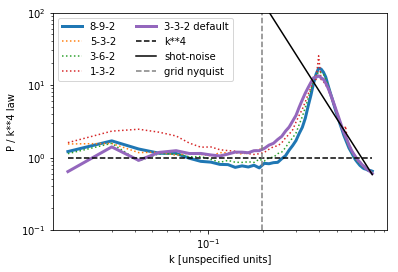

In [51]:
print('------')

state = test_solver(spread=8, N=9, B=2)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=128)
powerlaw = (r.power['k'] ** 4 / 0.1 ** 4)* r.power.sel(method='nearest', k=[.1])['power'].real 
plot(r.power['k'], r.power['power'] / powerlaw, label='8-9-2', lw=3)


state = test_solver(spread=5, N=3, B=2)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=128)
plot(r.power['k'], r.power['power']  / powerlaw, label='5-3-2', ls=':')

state = test_solver(spread=3, N=6, B=2)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=128)
plot(r.power['k'], r.power['power']  / powerlaw, label='3-6-2', ls=':')

state = test_solver(spread=1, N=3, B=2)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=128)
plot(r.power['k'], r.power['power']  / powerlaw, label='1-3-2', ls=':')


state = test_solver(spread=3, N=3, B=2)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=128)
plot(r.power['k'], r.power['power'] / powerlaw, label='3-3-2 default', lw=3)

print('------')
plot(r.power['k'], powerlaw / powerlaw, label='k**4', ls='--', color='k')
plot(r.power['k'], 1  / (pm.Nmesh / pm.BoxSize).prod()  / powerlaw, label='shot-noise', ls='-', color='black')
axvline(2 * pi / pm.BoxSize[0] * pm.Nmesh[0] / 2, label='grid nyquist', ls='--', color='grey')

legend(ncol=2)
yscale('log')
ylim(0.1, 100)
xscale('log')
xlabel('k [unspecified units]')
ylabel('P / k**4 law')

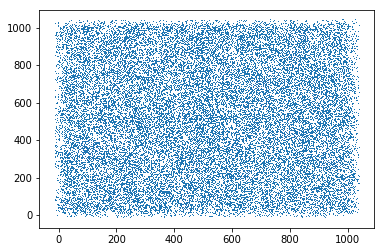

In [27]:
plot(state.X[:, 0], state.X[:, 1], ',')

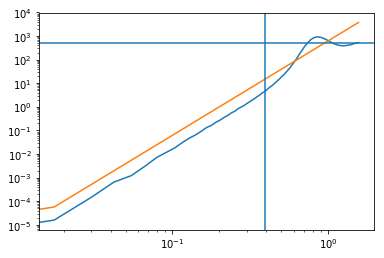

In [17]:
plot(r.power['k'], r.power['power'])
plot(r.power['k'], r.power['k'] ** 4 * r.power.sel(method='nearest', k=[1.])['power'].real)
axhline(1  / (pm.Nmesh / pm.BoxSize).prod())
axvline(2 * pi / pm.BoxSize[0] * pm.Nmesh[0] / 2)
yscale('log')
xscale('log')

In [46]:
h, b, b = histogram2d(state.X[:, 0] % pm.BoxSize[0], state.X[:, 1] % pm.BoxSize[1], bins=32)

(array([  1.,  11.,  75., 216., 294., 253., 126.,  40.,   7.,   1.]),
 array([22. , 24.1, 26.2, 28.3, 30.4, 32.5, 34.6, 36.7, 38.8, 40.9, 43. ]),
 <a list of 10 Patch objects>)

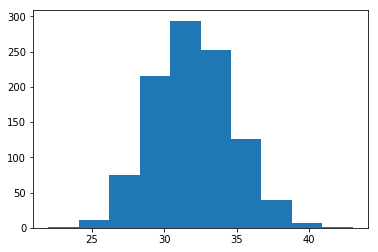

In [47]:
hist(h.flat)